Consider a current $I$ flowing counterclockwise in a loop in the xy-plane with a 3-petal shape as follows:

$$\vec{l}(t) = R\left[1+\frac{3}{4}\sin(3 t)\right] \cdot \left<\cos t, \sin t, 0 \right> $$

where $0 \leq t \leq 2\pi$. The Biot-Savard Law tells us

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3} = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$

Putting this in dimensionless form

* $\vec{l} \to \vec{l}/R$
* $\vec{r} \to \vec{r}/R$

we get

$$\frac{4 \pi R}{\mu_0 I} \vec{B}(\vec{r}) = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
from IPython.display import HTML
from IPython.display import Image, display
from IPython.core.display import HTML

Start by looking at curve

In [2]:
def cot(y):
  if not np.all(np.isclose(np.tan(y), 0.0)):
    return 1/np.tan(y)
  else:
      return 0

def floor(x): 
    return (-0.5 + x + np.arctan(cot(np.pi * x))/np.pi)

def l(phi):
    return (((np.cos(np.pi/4))/(np.cos(phi- (np.pi/2) * floor((4*phi + np.pi)/(2*np.pi))))) * np.array([np.cos(phi), np.sin(phi), np.zeros(len(phi))]))

In [3]:
t = np.linspace(0, 2 * np.pi, 1000)
lx, ly, lz = l(t)

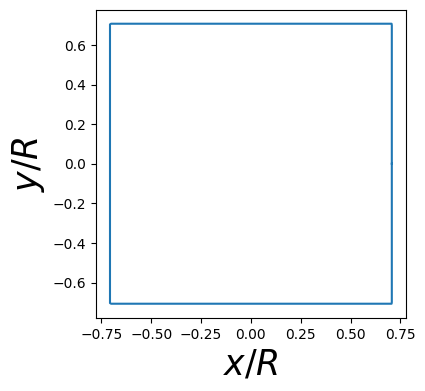

In [4]:
plt.figure(figsize=(4, 4))
plt.plot(lx, ly)
plt.xlabel('$x/R$', fontsize=25)
plt.ylabel('$y/R$', fontsize=25)
plt.show()

In [5]:
# t, x, y, z = smp.symbols('t, x, y, z')
rprime = l(t)
x = 0.5
y = 0.5
z = 0

Get $\vec{r}'$, $\vec{r}$, and the seperation vector $\vec{r} - \vec{r}'$

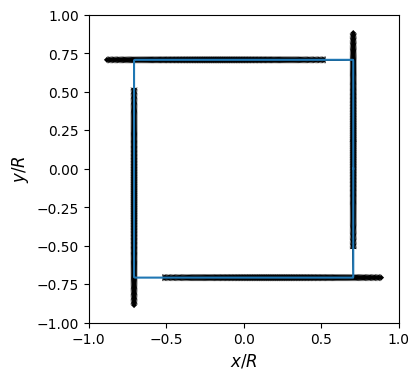

In [6]:
# slicing a numpy array with None allows you to multiply together arrays of different sizes to make a larger array
r = np.array([x, y, z])[:, None] * np.ones(rprime.shape)
sep = r - rprime

# Need to define the tangent vector to the curve everywhere 
dl = np.zeros(rprime.shape)
dl[2, :] = 0.0  # z-component of the tangent vector is always zero
for i in range(len(t)):
    # tangent vector in the +yhat direction
    if t[i] < np.pi / 4.0 or t[i] >= 7.0 * np.pi / 4.0:
        dl[0, i] = 0.0
        dl[1, i] = 1.0
    # tangent vector in the -xhat direction
    if t[i] >= np.pi / 4.0 and t[i] < 3 * np.pi / 4.0:
        dl[0, i] = -1.0
        dl[1, i] = 0.0
    # tangent vector in the -yhat direction
    if t[i] >= 3.0 * np.pi / 4.0 and t[i] < 5.0 * np.pi / 4.0:
        dl[0, i] = 0.0
        dl[1, i] = -1.0
    # tangent vector in the +xhat direction
    if t[i] >= 5.0 * np.pi / 4.0 and t[i] < 7.0 * np.pi / 4.0:
        dl[0, i] = 1.0
        dl[1, i] = 0.0

# Plot the curve again with the dl vectors on there
plt.figure(figsize=(4, 4))
plt.plot(lx, ly)
plt.quiver(lx, ly, dl[0, :], dl[1, :], scale=10, headwidth=10)
plt.xlabel('$x/R$', fontsize=12)
plt.ylabel('$y/R$', fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

Define the integrand

In [7]:
print(dl.shape, sep.shape)
integrand = np.cross(dl.T, sep.T) / np.linalg.norm(sep) ** 3
print(integrand.shape)

# Now do the sum over all the points of the rectangle (an approximation of the integral)
# Note that integral (...) dphi is approximately the same as
# sum_{i=1}^N (...) dphi_i, for many points, N >> 1. Since our phi variables
# is uniformly spaced around 0, 2 * pi, we can define dphi_i = phi[1] - phi[0],
# and that spacing will be the same at all points.
dphi = t[1] - t[0]
B = np.sum(integrand, axis=0) * dphi
print(B)  # You will need to check that this value is correct! 

(3, 1000) (3, 1000)
(1000, 3)
[0.         0.         0.00011619]


Set up a meshgrid to solve for the field in some 3D volume

In [8]:
# Define a uniform 3D mesh
x = np.linspace(-2, 2, 20)
xv, yv, zv = np.meshgrid(x, x, x)

# Flatten the points so that the next lines are easier to code
xv = np.ravel(xv)
yv = np.ravel(yv)
zv = np.ravel(zv)
r = np.array([xv, yv, zv])

# Use fancy numpy slicing with None to get nice 3D vectors
sep = r[:, :, None] - rprime[:, None, :]
dl2 = dl[:, None, :] * np.ones(sep.shape[1])[None, :, None]

# Makes the coordinate dimension of size 3 the last dimension of the 3D arrays sep and dl2
sep = np.transpose(sep, axes=[1, 2, 0])
dl2 = np.transpose(dl2, axes=[1, 2, 0])
print(r.shape, rprime.shape, sep.shape, dl2.shape)

# Notice sep is now shape (number of coordinates, number of evaluation points, number of integral points on the wire)
# dl2 is unchanged from dl but needs to made into the same shape as sep 

(3, 8000) (3, 1000) (8000, 1000, 3) (8000, 1000, 3)


In [9]:
integrand = np.cross(dl2, sep) / (np.linalg.norm(sep, axis=-1) ** 3)[:, :, None]
B_field = np.sum(integrand, axis=1) * dphi
print(integrand.shape, B_field.shape)

# Reshape the Bfield
B_field = B_field.reshape(len(x), len(x), len(x), 3)
Bx = B_field[:, :, :, 0]
By = B_field[:, :, :, 1]
Bz = B_field[:, :, :, 2]

(8000, 1000, 3) (8000, 3)


In [10]:
# Looks like some truncation to avoid divergent Bfield at the location of the wire?

Bx[Bx>20] = 20
By[By>20] = 20
Bz[Bz>20] = 20

Bx[Bx<-20] = -20
By[By<-20] = -20
Bz[Bz<-20] = -20

Use plotly to make an interactive 3D plot

In [11]:
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=20)

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2))) 

fig = go.Figure(data = data, layout=layout)
fig.add_scatter3d(x=lx, y=ly, z=lz, mode='lines',
                   line = dict(color='green', width=10))

HTML(fig.to_html())
fig.write_html('first_figure.html', auto_open=True)